In [1]:
%load_ext watermark
%watermark -u -d -m -v -p numpy,matplotlib,iris,xarray

last updated: 2016-08-18 

CPython 3.5.2
IPython 5.1.0

numpy 1.10.4
matplotlib 1.5.2
iris 1.9.2
xarray 0.8.1

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 3.13.0-93-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
%matplotlib inline

In [3]:
import datetime
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import numpy as np
import os
import string
import xarray
#
import umtools.irismode as umi
import umtools.utils as umu
from faamtools.core import parse_profiles_runs_info, read_core_nc
#
import map_plot_func as mymap
import mypaths
import plot_params as pp
import misc_utils as misc

In [4]:
uchar_list = list(string.ascii_uppercase)
lchar_list = list(string.ascii_lowercase)

In [5]:
iris.FUTURE.netcdf_promote = True
iris.FUTURE.cell_datetime_objects = True
um_res = umu.grdstep('km2p2')
fcst_init = '25_1200'

In [6]:
fcst_init_dt = datetime.datetime.strptime('201303'+fcst_init, '%Y%m%d_%H%M')

In [7]:
plt.style.use('awesome')

In [8]:
fmt = 'pdf'
svfigkw = dict(dpi=300, bbox_inches='tight', format=fmt)

## Input data

### Aircraft data

In [9]:
faam = read_core_nc(mypaths.faamf, time2datetime=True)

In [10]:
fltime = faam.time.val

In [11]:
fl_seg = parse_profiles_runs_info(os.path.join(mypaths.faamdir, 'sawtooth_summary.txt'), daystr='20130326')
extra_points = []
for iseg, xsh, ysh in zip(fl_seg[1:5],[0.5,0.5,-0.5,-1],[0,0,-0.1,0]):
    i_end = np.argmin([abs(i.total_seconds()) for i in faam.time.val - datetime.datetime.strptime(iseg[2], '%Y%m%d%H%M%S')])
    extra_points.append(dict(lon=faam.lon.val[i_end]+xsh, lat=faam.lat.val[i_end]+ysh))
    
extra_points = [dict(name=i, **j) for i, j in zip(uchar_list, extra_points)]

In [12]:
flx = xarray.open_dataset(mypaths.fluxf)
flx_b763_inds = np.where(flx.BXXX.values == 763)[0]

flx_coord = (flx.time.values.astype('<M8[us]').astype(datetime.datetime)[flx_b763_inds], flx.lat.values[flx_b763_inds], flx.lon.values[flx_b763_inds])

In [13]:
flx_time = flx.time.values.astype('<M8[us]').astype(datetime.datetime)[flx_b763_inds]
flx_lat, flx_lon = flx.lat.values[flx_b763_inds], flx.lon.values[flx_b763_inds]

In [14]:
the_time = flx_time[len(flx_time)//2]

### UM

In [15]:
# (0,15, 71.,75)
mapkw = dict(lon1=0,lon2=15,lat1=71,lat2=75,tick_incr=[2.,1.], resolution='c', scale=True)

In [16]:
def cleaner(cube, field, filename):
    cube.coord('time').var_name = 'time'
    for i_auxcoord in cube.aux_coords:
        if i_auxcoord.name() == u'forecast_period':
            cube.remove_coord(i_auxcoord)

In [17]:
fs = iris.load(os.path.join(mypaths.extdir, 'UM', 'exp_results', um_res.key, fcst_init, 'obs', 'processed', '*surf*11-14h*proc*'), 
               callback=cleaner).concatenate()

In [19]:
lhf = fs.extract('surface_upward_latent_heat_flux', strict=True)
lhf = lhf.extract(iris.Constraint(time=umu.nearest_tval(lhf, the_time)))
shf = fs.extract('surface_upward_sensible_heat_flux', strict=True)
shf = shf.extract(iris.Constraint(time=umu.nearest_tval(shf, the_time)))

In [20]:
lon2d, lat2d = umu.unrotate_xy_grids(shf)

In [21]:
cmap = plt.cm.Reds

cmap.set_under('w')
cmap.set_over('k')

In [22]:
shf_cmap = lhf_cmap = cmap
lhf_kw = dict(cmap=lhf_cmap, vmin=50, vmax=300, latlon=True)  # levels=np.arange(0,350,50), 
shf_kw = dict(cmap=shf_cmap, vmin=50, vmax=300, latlon=True)  # levels=np.arange(0,450,50), 

In [23]:
varlist = [
    dict(cube=shf, obs=flx.SH_coare.values[flx_b763_inds], short_name='SHF', conkw=shf_kw),
    dict(cube=lhf, obs=flx.LH_coare.values[flx_b763_inds], short_name='LHF', conkw=lhf_kw)
]

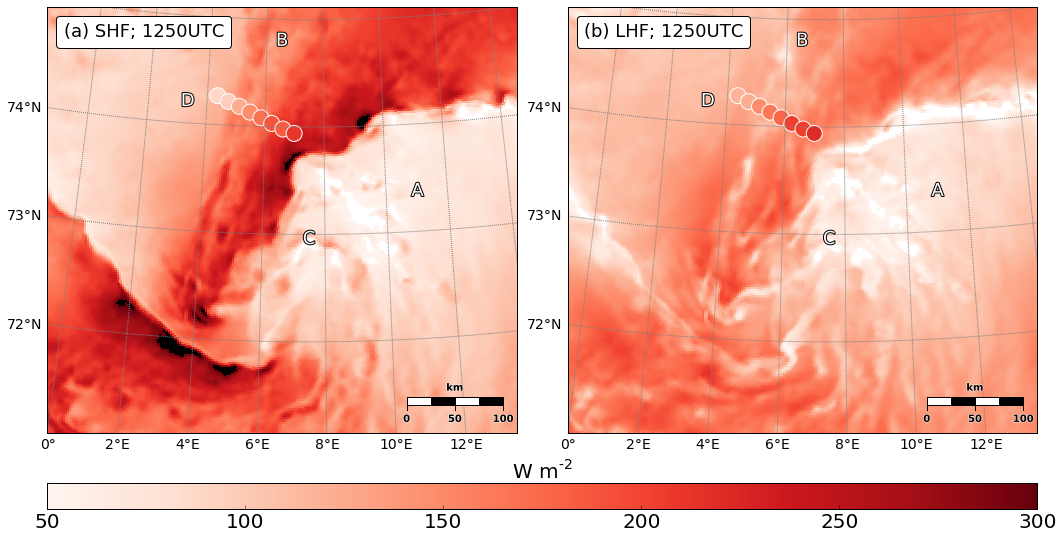

In [24]:
fig = plt.figure(figsize=(18,9))
grid = AxesGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.7, 
                cbar_location='bottom', cbar_mode='single', cbar_pad=0., cbar_size='3%')

for n, (iax, ivar, lchar) in enumerate(zip(grid, varlist, lchar_list)):
    bm = mymap.make_map(ax=iax,**mapkw)
    c = bm.pcolormesh(lon2d, lat2d, ivar['cube'].data, rasterized=True, **ivar['conkw'])
    sc = bm.scatter(flx_lon, flx_lat, c=ivar['obs'], s=2**8, edgecolors='w', **ivar['conkw'])
    cb = grid.cbar_axes[n].colorbar(c)
    cb.ax.tick_params(labelsize=20)
    cb.ax.xaxis.set_ticks(np.linspace(ivar['conkw']['vmin'], ivar['conkw']['vmax'],6))
    cb.ax.set_title('$W$ $m^{-2}$', fontsize=20)
    cb.solids.set_edgecolor("face")
    
    dt = umi.get_cube_datetimes(ivar['cube'])[0]
    txt = '({lab}) {name}; {dt}UTC'.format(lab=lchar, name=ivar['short_name'], dt=dt.strftime('%H%M'))
    at = AnchoredText(txt, prop=dict(size=18), frameon=True, loc=2)
    at.patch.set_boxstyle('round', pad=0., rounding_size=0.2)
    iax.add_artist(at)


    for p in extra_points:
        ix, iy = bm(p['lon'], p['lat'])
        iax.annotate(p['name'], (ix, iy), size=18, ha="center", color='w',
                     path_effects=[PathEffects.withStroke(linewidth=2,  foreground="k")])

imgname = 'shf_lhf_bulk_obs_vs_um_{time}.{fmt}'.format(time=dt.strftime('%Y%m%d_%H%M'), fmt=fmt)
fig.savefig(os.path.join('figures', imgname), **svfigkw)